# Тестовое задание Учебный портал


1. [Задание №1 Результаты A/B теста](#AB)
    - [Подготовка данных](#start)
    - [Сравнение конверсий](#CR)
    - [Сравнение средних чеков](#rev)
    - [Общий вывод](#end)


2. [Задание №2 SQL](#SQL)
    - [Задача 2.1](#2_1)
    - [Задача 2.2](#2_2)


3. [Задание №3 Python](#Python)


____
## Задание №1 <a id="AB"></a>

В ходе тестирования одной гипотезы была предложена **новая механика оплаты услуг** на сайте Uchi.ru, у контрольной группы оставалась базовая механика.

**Задача:** проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

#### Исходные данные:
* `groups` — информация о принадлежности пользователя к контрольной группе или экспериментальной группе (А-контроль, В-целевая группа)
* `active_studs` — информация о пользователях, которые зашли на платформу в дни проведения эксперимента
* `checks` — информация об оплатах пользователей в дни проведения эксперимента

**Вопросы:**
  * на какие метрики вы смотрите в ходе анализа и почему?
  * имеются ли разлия в показателях и с чем они могут быть связаны?
  * являются ли различия статистически значимыми?
  * стоит ли запускать новую механику на всех пользователей?

-------
### 1. Подготовка данных <a id="start"></a>


Импотртируем необходимые библиотеки и таблицы.

In [1]:
# обработка данных
import pandas as pd

# проверка гипотез
from scipy import stats as st
import numpy as np
import math as mth

# построение графиков
from matplotlib import pyplot as plt
import pylab

In [2]:
checks = pd.read_csv(r'C:\Users\Пользователь\Documents\my_docs\uchi\checks.csv', ';')
active_studs = pd.read_csv(r'C:\Users\Пользователь\Documents\my_docs\uchi\active_studs.csv')
groups = pd.read_csv(r'C:\Users\Пользователь\Documents\my_docs\uchi\groups.csv', ';')

In [3]:
# посмотрим на инфомрацию о таблицах
groups.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74576 entries, 0 to 74575
Data columns (total 2 columns):
id     74576 non-null int64
grp    74576 non-null object
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


In [4]:
# проверим не попал ли один и тот же пользователь сразу в обе группы
groups['id'].value_counts().sort_values(ascending=False).head(5)

2754561    1
1517348    1
104499     1
315418     1
4449747    1
Name: id, dtype: int64

In [5]:
active_studs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8341 entries, 0 to 8340
Data columns (total 1 columns):
student_id    8341 non-null int64
dtypes: int64(1)
memory usage: 65.2 KB


In [6]:
checks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 2 columns):
student_id    541 non-null int64
rev           541 non-null float64
dtypes: float64(1), int64(1)
memory usage: 8.5 KB


Пропусков в данных нет, типы присвоены корректно. Пользователи не дублируются в группах.

Далее соберем все данные в одной таблице.

In [7]:
# добавляем информацию о кол-ве активных пользователей
active_studs = active_studs['student_id'].unique()
groups['active_studs'] = groups['id'].apply(lambda x: 1 if x in active_studs else 0)

In [8]:
# добавляем данные об оплатах
groups = groups.merge(checks, left_on='id', right_on='student_id', how='outer')
groups = groups.drop(columns=['student_id'])

In [9]:
# приводим данные к удобному рабочему виду
groups['rev'] = groups['rev'].fillna(0)
groups['payed_studs'] = groups['rev'].apply(lambda x: 1 if x != 0 else 0)
groups.head()

,id,grp,active_studs,rev,payed_studs
0,1206794,B,0,0.0,0
1,331024,B,0,0.0,0
2,1733498,A,0,0.0,0
3,161574,B,0,0.0,0
4,168443,B,0,0.0,0


Теперь можем перейти к сравнению показателей и проверке гипотез.


### 2. Проверка гипотез

Для оценки эффективности теста, будем использовать следующие показатели:
    1. Конверсия в оплату (CR, CR_active)
    2. Показатели выручки: средний чек и средний доход от каждого пользователя(ARPU, ARPAU)
    
Внедрение новой механики оплаты вряд ли направлено на изменение количества активных пользователей, поэтому данный показатель в расчет брать не будем.

Рассчитаем необходимые показатели.

In [10]:
# группируем данные по группам
t = groups.groupby('grp').agg({'id':'count','active_studs':'sum', 'payed_studs':'sum', 'rev':'sum'})
t = t.rename(columns = {'id':'cnt_studs'})

# добавляем данные по объединенной группе
new_row = t.loc['A'] + t.loc['B']
new_row.name = 'A+B'
t = t.append([new_row])

# добавляем дополнительные расчетные столбцы
t['active_part'] = (t['active_studs']/t['cnt_studs']) # доля активных пользователей
t['СR_active'] = (t['payed_studs']/t['active_studs']) # конверсия в оплату из активных пользователей
t['СR'] = (t['payed_studs']/t['cnt_studs']) # конверсия в оплату
t['check'] = (t['rev']/t['payed_studs']) # средний чек
t['ARPAU'] = (t['rev']/t['active_studs']) # средний доход от каждого активного пользователя
t['ARPU'] = (t['rev']/t['cnt_studs']) # средний доход от каждого пользователя

t

,cnt_studs,active_studs,payed_studs,rev,active_part,СR_active,СR,check,ARPAU,ARPU
A,14693.0,1538.0,107.0,92096.0000,0.104676,0.069571,0.007282,860.710280,59.880364,6.268019
B,59883.0,6803.0,434.0,481230.0036,0.113605,0.063795,0.007247,1108.824893,70.737910,8.036171
A+B,74576.0,8341.0,541.0,573326.0036,0.111846,0.064860,0.007254,1059.752317,68.735883,7.687808


### 2.1 Сравнение конверсий <a id="CR"></a>
Сравним контрольную и тестовую группу через гипотезу о равенстве долей с помощью z-критерия.

* Нулевая гипотеза: конверсии равны между собой
* Альтернатива: конверсии отличаются

In [11]:
def statt(col1, col2):

        alpha = .05 # критический уровень статистической значимости
        
        q1 = t.query('index == "A"')
        q2 = t.query('index == "B"')
        q3 = t.query('index == "A+B"')
    
        p1 = q1[col1].sum()/q1[col2].sum()
        p2 = q2[col1].sum()/q2[col2].sum()
        p_combined = q3[col1].sum()/q3[col2].sum()
        difference = p1 - p2

        z_value = difference/mth.sqrt(p_combined*(1-p_combined)*(1/q1[col2].sum()+1/q2[col2].sum()))

        distr = st.norm(0,1)

        p_value = (1 - distr.cdf(abs(z_value)))*2
    
        print('p-значение: {:.4f}'.format(p_value))

        if (p_value < alpha):
            print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
        else:
            print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать конверсии разными")

In [12]:
statt('payed_studs', 'cnt_studs')

p-значение: 0.9644
Не получилось отвергнуть нулевую гипотезу, нет оснований считать конверсии разными


In [13]:
statt('payed_studs', 'active_studs')

p-значение: 0.4062
Не получилось отвергнуть нулевую гипотезу, нет оснований считать конверсии разными


По результатам теста с 5% точностью, статистически значимых различий в конверсиях не обнаружено.

### 2.2. Сравнение средних чеков <a id="rev"></a>

Для проверки различий в среднем чеке сначала необходимо проверить нормальность распределения. Для этого построим QQ график.

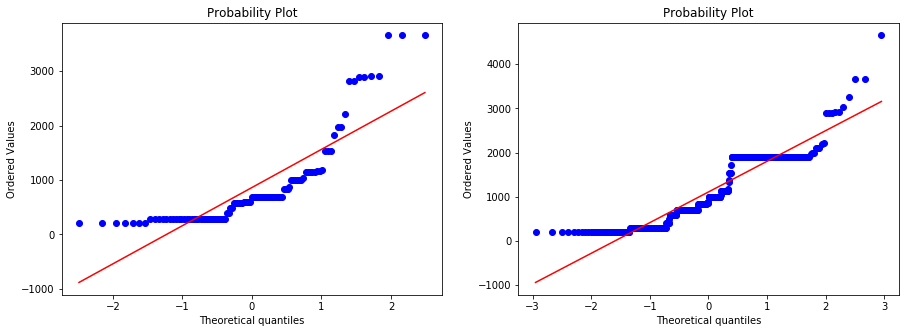

In [14]:
pylab.figure(figsize=(15,5))
pylab.subplot(1,2,1)
st.probplot(groups.query('payed_studs != 0 & grp == "A"')['rev'], dist='norm', plot=pylab)

pylab.subplot(1,2,2)
st.probplot(groups.query('payed_studs != 0 & grp == "B"')['rev'], dist='norm', plot=pylab)
pylab.show()

По графикам видно, что распределения похожи на нормальные, но есть точки, которые лежат довольно далеко от прямой. Поэтому сделаем дополнительную проверку, используя **критерий Шапиро-Уилка**.

**Сформулируем нулевую и альтернативную гипотезы:**
- Нулевая гипотеза: распределение нормальное
- Альтернатива: распределение отличное от нормального

In [15]:
alpha = .05 # уровень статистической значимости

results = st.shapiro(groups.query('payed_studs != 0')['rev'])
p_value = results[1]

print('p-значение: {:.25f}'.format(p_value))

if (p_value < alpha):
    print("Отвергаем нулевую гипотезу: распределение отличное от нормального")
else:
    print("Не получилось отвергнуть нулевую гипотезу, распределение нормальное")

p-значение: 0.0000000000000000000038619
Отвергаем нулевую гипотезу: распределение отличное от нормального


По результатам теста распределение получилось отличным от нормального, поэтому для проверки сравнения средних чеков двух выборок, будем использовать непараметрический **тест Манна-Уитни**.

* Нулевая гипотеза: чеки равны между собой
* Альтернатива: чеки отличаются

In [16]:
alpha = .05 # уровень статистической значимости

A = groups.query('grp == "A" & rev != 0')['rev']
B = groups.query('grp == "B" & rev != 0')['rev']

results = st.mannwhitneyu(A,B)
p_value = results[1]

print('p-значение: {:.4f}'.format(p_value))

if (p_value < alpha):
    print("Отвергаем нулевую гипотезу: между чеками есть значимая разница")
else:
    print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать чеки разными")


p-значение: 0.0001
Отвергаем нулевую гипотезу: между чеками есть значимая разница


In [17]:
# Рассчитаем относительную разницу в чеке и выручке на пользователя
print("Средний чек группы B больше чека группы А на {:.2%}".format((B.mean()-A.mean())/B.mean()))


Средний чек группы B больше чека группы А на 22.38%


### 3. Итоги А/B теста <a id="end"></a>

По итогам проверки результатов теста значимых различий в конверсиях двух групп не обнаружено.
А вот изменения в среднем чеке оказались статистически значимыми, чек группы **Б** больше чека группы **А** на 22%. Также есть разница и в среднем доходе на пользователя.

Для того, чтобы говорить о том, стоит ли запускать новую механику оплаты на всех пользователей, нужно понимать целевые показатели эксперимента. Если целевым показателем было изменение выручки на пользователя, то эксперимент можно считать успешным. 
Если тест был направлен на увеличение конверсии, то значимых изменений не обнаружено и нужно тестировать другую гипотезу.

------
## Задание №2. SQL <a id="SQL"></a>
#### 2.1 Написать `оптимальный запрос`, который даст информаию о количестве очень усердных** студентов за март 2020 года. <a id="2_1"></a>

***хотя бы раз за указанный месяц правильно решил 20 горошин за час*

Таблица **peas**:

<table>

<td><b>Название атрибута</b></td>
<td><b>Тип атрибута</b></td>
<td><b>Смысловое значение</b></td>
<tr>

<td> st_id </td>
<td> int </td>
<td> ID ученика </td>
<tr>
    
<td> timest </td>
<td> timestamp </td>
<td> Время решения карточки </td>
<tr>
    
<td> correct </td>
<td> bool </td>
<td> Правильно ли решена горошина? </td>
<tr>
    
<td> subject </td>
<td> text </td>
<td> Дисциплина, в которой находится горошина </td>
<tr>
    


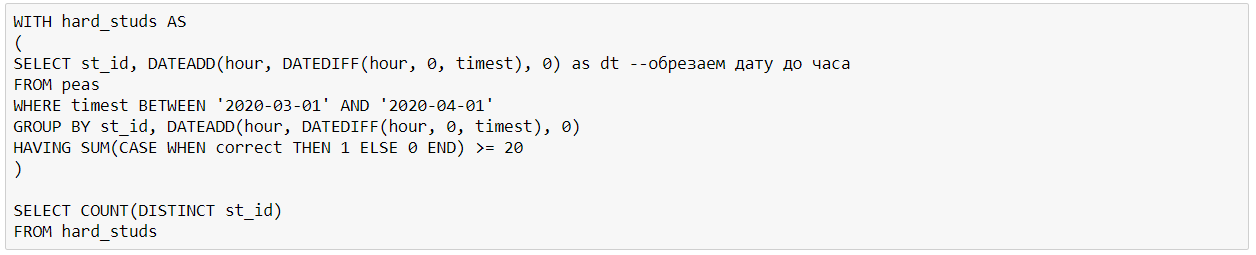

#### 2.2 В одном запросе выгрузить следующую информацию о группах пользователей: <a id="2_2"></a>

* `ARPU`
* `ARPAU`
* `CR` в покупку
* `CR` активного пользователя в покупку
* `CR` пользователя из активности по математике (subject = 'math') в покупку курса по математике

Таблица **studs**:
<table>

<td><b>Название атрибута</b></td>
<td><b>Тип атрибута</b></td>
<td><b>Смысловое значение</b></td>
<tr>

<td> st_id </td>
<td> int </td>
<td> ID ученика </td>
<tr>
    
<td> test_grp </td>
<td> text </td>
<td> Метка ученика в данном эксперименте </td>
<tr>
    
</table>
<br/><br/>

Таблица **checks**:
<table>

<td><b>Название атрибута</b></td>
<td><b>Тип атрибута</b></td>
<td><b>Смысловое значение</b></td>
<tr>

<td> st_id </td>
<td> int </td>
<td> ID ученика </td>
<tr>
    
<td> sale_time </td>
<td> timestamp </td>
<td> Время покупки </td>
<tr>
    
<td> subject </td>
<td> text </td>
<td> Дисциплина, на которую приобрели полный курс </td>
<tr>

<td> money </td>
<td> int </td>
<td> Цена, по которой приобрели данный курс </td>
<tr>
    
</table>
<br/><br/>

<table>
</table>
<br/><br/>

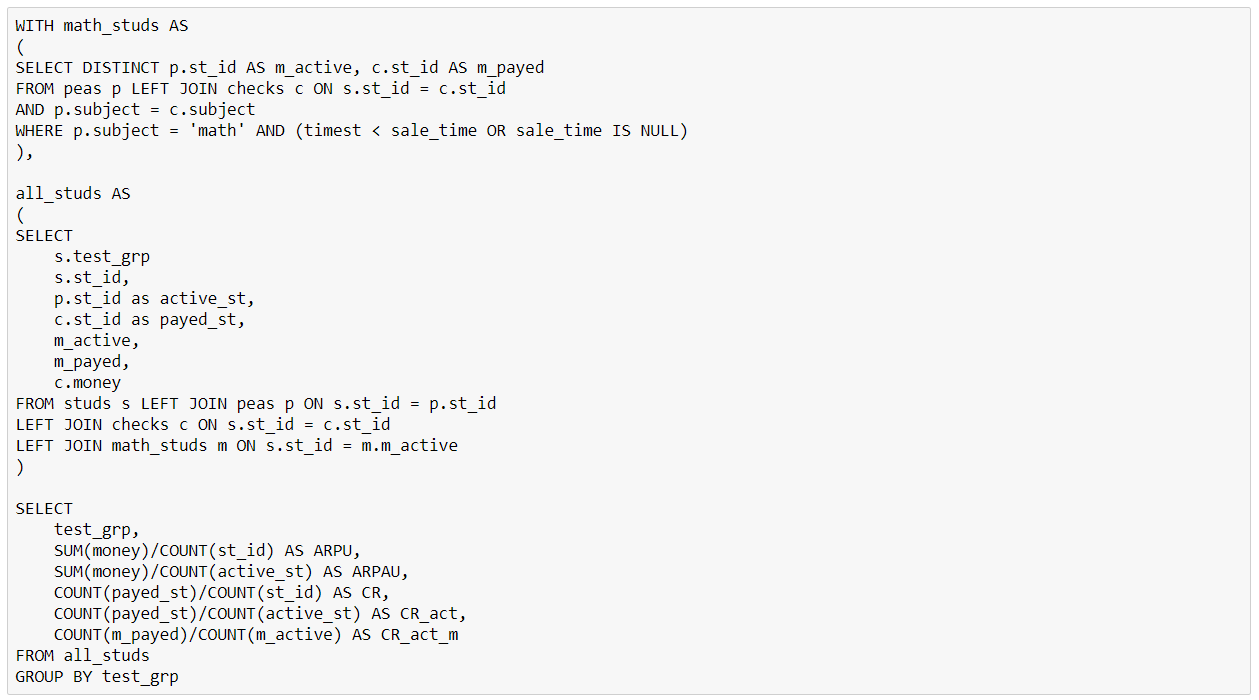

------
## Задача №3 Python <a id="Python"></a>

1. Создать класс BaseGraph со следующими атрибутами:
    * Источник данных (pandas.DataFrame или csv)
    * Название графика
    * Подписи осей
    * Другие параметры, которые, возможно, захочет увидеть пользователь
2. Создать метод plot, который будет строить line graph.
3. Создать BarGraph, который будет наследником BaseGraph. Переопределите метод plot, который будет адаптирован для построения bar chart.
4. Проиллюстрируйте работу написанных классов на собственных примерах, проверив, что ваш класс корректно обрабатывает все краевые случаи.

In [18]:
class BaseGraph:
    """Создаем класс для создания графика"""
    
    def __init__(self, source, name, x, y):
        """Задаем атрибуты класса"""
        self.source = source
        self.name = name
        self.x = x
        self.y = y
 
    def plot(self):
        """Пишем метод для построения графика"""
        self.kind = 'line'
        self.source.plot(kind=self.kind,
                         x=self.x,
                         y=self.y,
                         title = self.name)

class BarGraph(BaseGraph):
    """Задаем атрибуты класса"""
    def __init__(self, source, name, x, y):
        """Передаем атрибуты из класса BaseGraph"""
        super().__init__(source, name, x, y)
    def plot(self):
        """Переопределяем метод plot"""
        self.kind = 'bar'
        self.source.plot(kind=self.kind,
                         x=self.x,
                         y=self.y,
                         title = self.name)


In [19]:
# создадим таблицу с данными для проверки классов
d = {'col1': np.arange(0,10),'col2': np.random.normal(loc=3, scale=0.7, size=10)}
data = pd.DataFrame(data=d)
data

,col1,col2
0,0,3.278994
1,1,3.390928
2,2,3.338761
3,3,3.128358
4,4,3.617299
5,5,3.094786
6,6,3.538890
7,7,3.596674
8,8,3.071131
9,9,2.453586


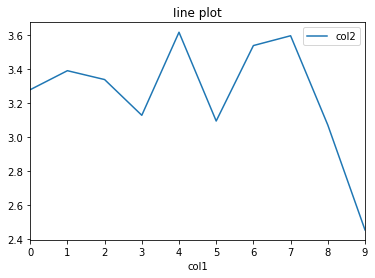

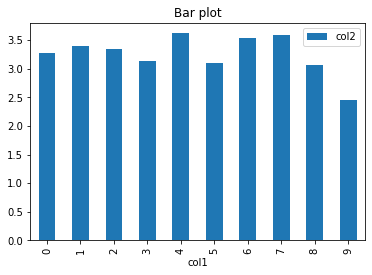

In [20]:
base_graph = BaseGraph(data, 'Iine plot', 'col1', 'col2')
base_graph.plot()

bar_graph = BarGraph(data, 'Bar plot', 'col1', 'col2')
bar_graph.plot()